# (Extra) Convolutional Neural Network (CNN)

In diesem Notebook schauen wir uns Convolutional Neural Network an.

In der Praxis verwendet man für grosse Mengen an Bilddaten üblicherweise Convolutional Neural Networks (CNNs).
Diese haben wir im Theorie Teil aber nicht im Detail angeschaut, darum ist diese Lösung als `Extra` zu verstehen.

Dieses Notebook soll als Einstieg zu `CNN` verstanden werden. Mit `CNN` kann man noch deutlich mehr Genauigkeit herausholen.
Das Modell hier wurde bewusst klein gehalten, dass man es auch auf einer `CPU` trainieren kann.
Üblicherweise werden CNNs aus Performanzgründen auf `GPUs` (oder `TPUs`) trainiert.

In [24]:
!pip install tensorflow==2.6
!pip install keras==2.6

You should consider upgrading via the '/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/bin/python -m pip install --upgrade pip' command.


In [25]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, activations, Sequential, losses
from tensorflow.keras.regularizers import L2

import pickle

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [27]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    """
        Takes true and predicted labels (arrays) as input. Based on this, calculates and plots a confusion matrix.
    """
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Daten vorbereiten

In [28]:
# Daten laden und aufteilen in Features und Labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

##### Preprocessing

Für tensorflow müssen wir die Text-Labels (wie `frog`) in Zahlen umwandeln. Dazu verwenden wir den `LabelEncoder`.

Die Daten werden hier mittels `tf.image.per_image_standardization` standardisiert.

In [30]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [31]:
# tf.image.per_image_standardization ist ein übliches Preprocessing für Bilddaten.
X_train_std = tf.image.per_image_standardization(X_train).numpy()
X_val_std = tf.image.per_image_standardization(X_val).numpy()

#### CNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Conv2D)      (None, 15, 15, 32)        896       
_________________________________________________________________
hidden_layer_2 (Conv2D)      (None, 7, 7, 64)          18496     
_________________________________________________________________
hidden_layer_3 (Conv2D)      (None, 3, 3, 128)         73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 94,538
Trainable params: 94,538
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
586/586 [==============================] - 19s 30ms/step - loss: 1.8038 - accuracy: 0.3675 - val_los

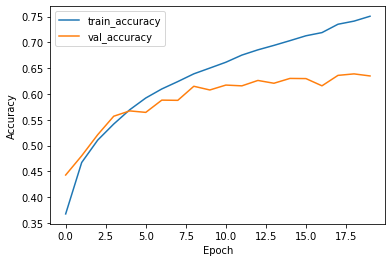

0.63496
CPU times: user 21min 25s, sys: 11min 31s, total: 32min 56s
Wall time: 5min 32s


In [32]:
%%time

from keras.regularizers import l2

# Neural Network mit zwei Hidden Convolution Layers
cnn = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
    layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=activations.relu, name='hidden_layer_1'),
    layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activations.relu, name='hidden_layer_2'),
    layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activations.relu, name='hidden_layer_3'),
    layers.GlobalAvgPool2D(),
    layers.Dense(10, activation=activations.linear, name='output_layer', bias_regularizer=l2(), kernel_regularizer=l2()),
])

print(cnn.summary())

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

cnn.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

history = cnn.fit(X_train_std, y_train_enc, batch_size=64, epochs=20, validation_data=(X_val_std, y_val_enc))
plot_history(history)

y_val_hat_prob = cnn.predict(X_val_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

Unser CNN Model hat "nur" `94'538 Parameter`, sprich deutlich weniger als das Feed-Forward Neural Network der anderen Beispielslösung.

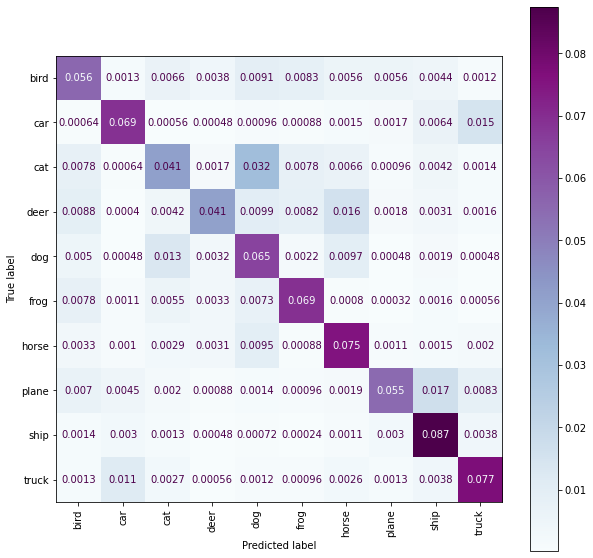

In [33]:
plot_confusion_matrix(
    y_true=y_val,
    y_pred=le.inverse_transform(y_val_hat)
)

# Anwendung des Modells auf dem Test Set

Wenn wir mit der Leistung unseres Modells auf dem `Validation Set` zufrieden sind, können wir es auf das `Test Set` anwenden.

In [34]:
# Daten laden und aufteilen in Features und Labels
with open('../data/test.pkl', 'rb') as f:
    data_test = pickle.load(f)
X_test = data_test["images"]
y_test = data_test["labels"]

In [38]:
X_test_std = tf.image.per_image_standardization(X_test).numpy()
# Das Neurale Netz gibt Wahrscheinlichkeiten zurück
y_test_pred_prob = cnn.predict(X_test_std)
# Hier nehmen wir den Klassen-Index mit der höchsten Wahrscheinlichkeit
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
# Und verwandeln diesen Klassen-Index (z.B. 1) in das entsprechende Klassen-Label (z.B. 'car')
y_test_pred_enc = le.inverse_transform(y_test_pred)

Evaluieren wir unsere test-set predictions

In [39]:
accuracy_score(y_true=y_test, y_pred=y_test_pred_enc)

0.6277